# Imports

In [33]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from ipywidgets import interact, fixed, interact_manual

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, \
    VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

# GenAI
from google import genai
from google.genai import types

# natural data databases
import hapi
DB_PATH = 'hapi_data'
hapi.db_begin(DB_PATH)

# API setups
G_MODEL_ID = "gemini-2.5-flash-preview-05-20"
G_API_KEY = os.environ.get("GEMINI_API_KEY")
G_CLIENT = genai.Client(api_key=G_API_KEY)

response = G_CLIENT.models.generate_content(
    model=G_MODEL_ID,
    contents="test",
)

print(response.text)

pp = pprint.PrettyPrinter(depth=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using hapi_data

Hello! Test received. How can I help you today?


In [34]:
# custom
import sys
sys.path.append('../../../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
from my_utils.common import std_range
cp.hello_test()

Hello!


# Benchmark

In [30]:
pressure_list = [900]
freq_list_2 = [20, 30, 40]

benchmark_path_2 = "./"
benchmark_noise_2 = "./noise-tests/"

patterns = cp.create_regex_strings(pressure_list, freq_list_2)
patterns_2 = cp.create_regex_strings(pressure_list, freq_list_2, f="single")

test_bench_files = cp.dir_match_dict(benchmark_path_2, patterns) 
# pp.pprint(patterns)
pp.pprint(test_bench_files)

{900: {20: ['gasx_900_32_20__msr__0',
            'gasx_900_32_20__msr__1',
            'gasx_900_32_20__msr__2'],
       30: ['gasx_900_32_30__msr__3',
            'gasx_900_32_30__msr__4',
            'gasx_900_32_30__msr__5'],
       40: ['gasx_900_32_40__msr__6',
            'gasx_900_32_40__msr__7',
            'gasx_900_32_40__msr__8']}}


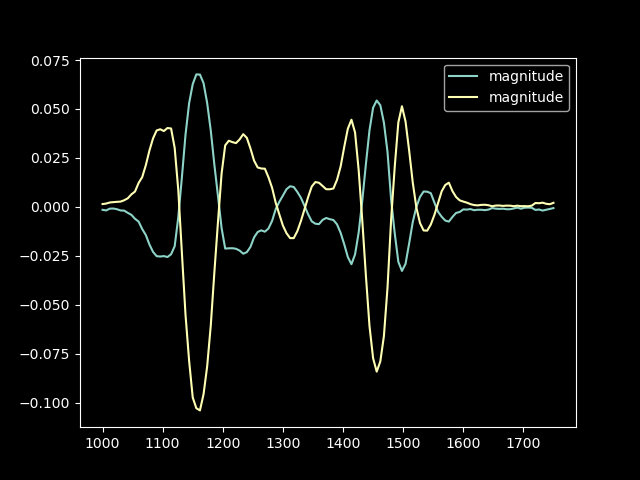

,time,offset1,P1,H3,H2,P_las,T_las,RH,Pressure,time_subtracted,H2_pnorm,H3_pnorm,wavenumbers,magnitude_pnorm
1,1131.555,1000.0,0.0,0.001146,-0.001212,0.02574,403.5192,32.22656,897.0,0.000,-0.042911,0.040598,6985.643439,0.059073
2,1133.360,1006.0,0.0,0.002432,-0.001457,0.02574,403.5192,32.22656,897.0,1.805,-0.051595,0.086116,6985.617254,0.100389
3,1135.164,1012.0,0.0,0.002691,-0.001454,0.02574,393.6961,32.20215,897.0,3.609,-0.051474,0.095305,6985.591070,0.108317
4,1137.093,1018.0,0.0,0.002398,-0.000365,0.02574,403.5192,32.22656,897.0,5.538,-0.012925,0.084910,6985.564885,0.085888
5,1139.080,1024.0,0.0,0.002442,-0.001342,0.02574,403.5192,32.20215,897.0,7.525,-0.047522,0.086489,6985.538700,0.098685


In [19]:


u1 = [1158.1, 1452.7]
u2 = [6984.9534710, 6983.6678]

# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 900
f = 20
bench_test_2 = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
# bench_test.self_test()
bench_test_2.add_wav(u1, u2)
bench_test_2.add_magnitude()
test_avg = bench_test_2.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
%matplotlib widget

plt.close()
plt.figure()
# 1st test
# plt.plot(bench_test_2.spectra.spectra_list[0]['offset1'], bench_test_2.spectra.spectra_list[0]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[1]['offset1'], bench_test_2.spectra.spectra_list[1]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[2]['offset1'], bench_test_2.spectra.spectra_list[2]['H2_pnorm'])
# plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
# plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')

# test magnitude
plt.plot(test_avg['offset1'], test_avg["H2"], label="magnitude")
plt.plot(test_avg['offset1'], test_avg["H3"], label="magnitude")

plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()
bench_test_2.spectra.spectra_list[0].head()

# Signal

## See all peaks

Uncomment below to see all the peaks used for bench

In [38]:
# plt.close()
# ps = [900]
# fs = [20, 30, 40]
# for p, f in itertools.product(ps, fs):
#     bench_test = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
#     bench_test.add_magnitude()
#     peak_start = 1435
#     peak_end = 1475
#     peak = bench_test.get_window(peak_start, peak_end)
#     peak_spline = bench_test.get_spline_of_window(n_spectrum=-1,
#                                                   n_knots=4,
#                                                   colx="offset1",
#                                                   coly="magnitude_pnorm",
#                                                   start=peak_start,
#                                                   end=peak_end)
#     # print(peak_spline[1])
#     print(peak_spline[-1])
#     plt.figure()
#     plt.plot(peak[0]['offset1'], peak[0]['magnitude_pnorm'])
#     plt.plot(peak[1]['offset1'], peak[1]["magnitude_pnorm"])
#     plt.plot(peak[2]['offset1'], peak[2]["magnitude_pnorm"])
#     plt.plot(peak[3]['offset1'], peak[3]['magnitude_pnorm'], label='avg')
#     plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['magnitude_pnorm'], label='spline of avg')
#     plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['magnitude_pnorm'], 'rx')
#     plt.legend()
#     plt.title(f"p={p}, f={f}")
#     plt.show()

# Noise

## See all noises

Uncomment to see all noises!!

In [39]:
noise_2_dict = cp.dir_match_dict(benchmark_noise_2, patterns_2)
pp.pprint(noise_2_dict)

{900: {20: ['single_900_32_20__msr__0'],
       30: ['single_900_32_30__msr__0'],
       40: ['single_900_32_40__msr__0']}}


In [40]:
# col_names = {
#     0: 'time',          # time (measurement tick, stopped on gasx, arbitrary)
#     1: 'offset1',       # DFB offset-1
#     2: 'P1',            # onboard pressure sensor (blue tube)
#     3: 'H3',            # 3rd harmonic (L1H1)
#     4: 'H2',            # 2nd harmonic (L1H2)
#     5: 'P_las',         # laser power (some volts)
#     6: 'T_las',         # diode temp (Kelvin)
#     7: 'RH',            # humidity sensor (external)
#     8: 'Pressure'       # sensor (external)
# }

# plt.close()
# new_noise_dict = {}
# n = 3
# y = 'H2'
# for k1 in noise_2_dict.keys():
#     new_noise_dict[k1] = {}
#     for k2, v2 in noise_2_dict[k1].items():

#         cm = CEPAS_measurement(path=benchmark_noise_2, path_signature=noise_2_dict[k1][k2][0], cols=col_names)
#         df = cm.spectra_list[0]
#         new_df, std, outliers = std_range(df, y, n)
#         Q1 = df[y].quantile(0.25)
#         Q3 = df[y].quantile(0.75)
#         IQR = Q3 - Q1

#         new_noise_dict[k1][k2] = std
#         plt.figure()
#         plt.plot(df.index, df[y], label=f"std = {std:.2e}")
#         plt.hlines([Q1-n*IQR, Q3+n*IQR], xmin=df.index.min(), xmax=df.index.max(), colors=['red', 'red'])
#         plt.legend()
#         plt.show()

4.405e-04


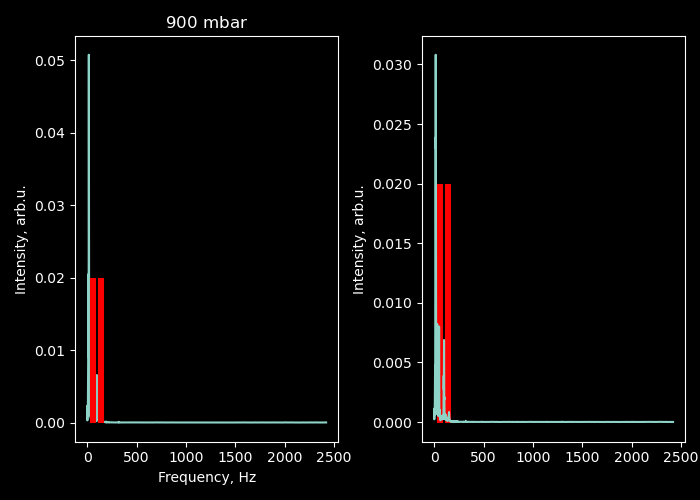

In [41]:
# bench_noise_300_2 = CEPAS_noise_info(benchmark_noise_2, 300)
# bench_noise_600_2 = CEPAS_noise_info(benchmark_noise_2, 600)
bench_noise_900_1 = CEPAS_noise_info(benchmark_noise_2, 900)
bench_noise_900_2 = CEPAS_noise_info(benchmark_noise_2, 900, 2)

# backgrounds = {300: bench_noise_300_2,
#                600: bench_noise_600_2,
backgrounds = {900: bench_noise_900_2}


print(f"{np.format_float_scientific(bench_noise_900_2.get_noise_at(f), precision=3)}")
plt.close()
plt.figure(figsize=(7, 5))
plt.subplot(122)
plt.ylabel('Intensity, arb.u.')
plt.vlines([40, 60, 80, 60*2, 70*2, 80*2],
            -0.0001, 0.02,
              colors=["red", "red", "red"],
                label="20, 30, 40, 60, 70, 80 Hz")
plt.plot(bench_noise_900_1.spectrum['freq'], bench_noise_900_1.spectrum['intensity'])
# plt.subplot(132)
# plt.title("$600\\ \\text{mbar}$")
# plt.xlabel('Frequency, Hz')
# plt.ylabel('Intensity, arb.u.')
# plt.plot(bench_noise_600_2.spectrum['freq'], bench_noise_600_2.spectrum['intensity'])
plt.subplot(121)
plt.title("$900\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_900_2.spectrum['freq'], bench_noise_900_2.spectrum['intensity'])
plt.vlines([40, 60, 80, 60*2, 70*2, 80*2],
            -0.0001, 0.02,
              colors=["red", "red", "red"],
                label="20, 30, 40, 60, 70, 80 Hz")
plt.tight_layout()
plt.show()

In [42]:
noise_start_2 = 1625
noise_end_2 = 1749
peak_start_2 = 1435
peak_end_2 = 1471

bench_final_2 = CEPAS_SNR_bench(test_bench_files,
                                bench_path=benchmark_path_2,
                                noise_path=benchmark_noise_2,
                                file_sig="single")

get_all = bench_final_2.get_mag_snrs(peak_start_2,
                                     peak_end_2,
                                     n_knots=4)

snrs = get_all[0]
noises = get_all[1]  # single, background
signals = get_all[2]

signals.index
bench_final_2

'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=900                         and f=20 signal is 
---->53    2.025339
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 0.0015991928782121518
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=900                         and f=30 signal is 
---->61    2.2002
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 0.00044969585035296194
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=900                         and f=40 signal is 
---->57    2.433189
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 0.001177028855040581


In [43]:
noises

,900
40,"[0.0015991928782121518, 0.0008668076296296297]"
60,"[0.00044969585035296194, 0.0004847030740740741]"
80,"[0.001177028855040581, 0.00038051037037037036]"


/tmp/ipykernel_2135/250908516.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'signal': [float(signals[900][f][0]) for f in snrs.index],
/tmp/ipykernel_2135/250908516.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


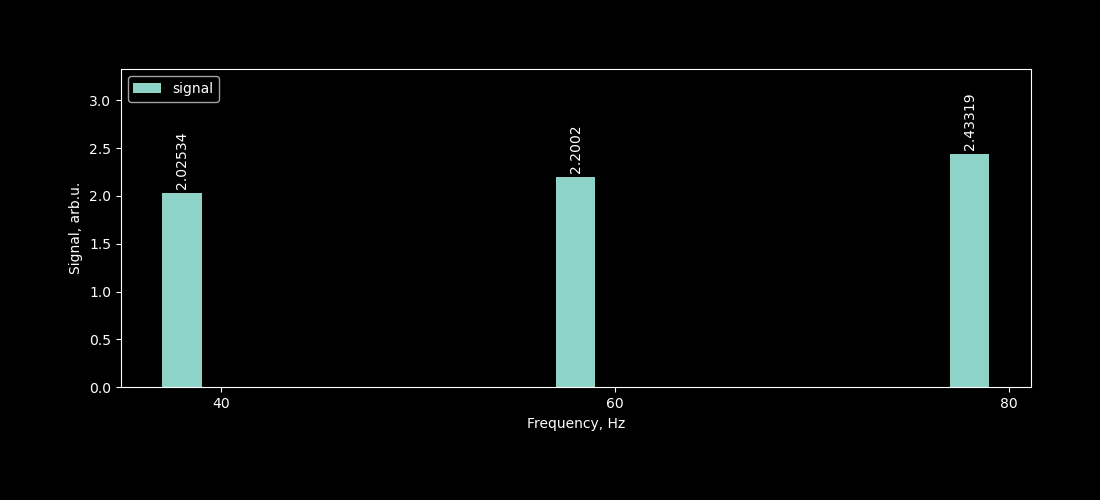

In [44]:
# signals300 = {
#     'signal': [float(signals[300][f][0]) for f in signals.index],
#     # 'background': [float(signals[300][f][1]) for f in signals.index]
# }

# signals600 = {
#     'signal': [float(signals[600][f][0]) for f in signals.index],
#     # 'background': [float(signals[600][f][1]) for f in signals.index]
# }

signals900 = {
    'signal': [float(signals[900][f][0]) for f in snrs.index],
    # 'background': [float(signals[900][f][1]) for f in snrs.index]
}

frequencies = snrs.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 5), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in signals300.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3)
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('Signal, arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
# multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in signals600.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3)
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('Signal, arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
# multiplier = 0

ax3 = plt.subplot(111)
for k, v in signals900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Signal, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

/tmp/ipykernel_2135/1465987185.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


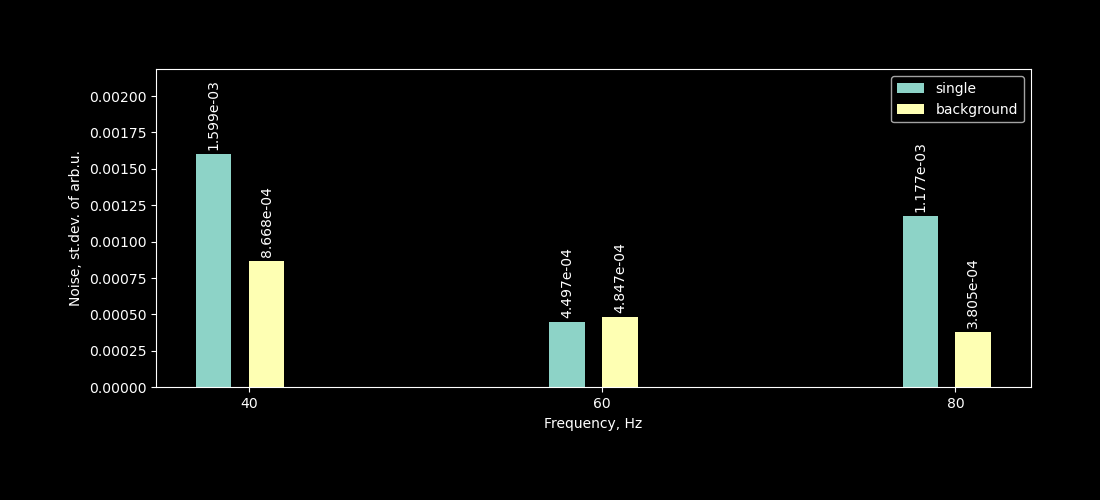

In [45]:
# noises300 = {
#     'single': [noises[300][f][0] for f in noises.index],
#     'background': [noises[300][f][1] for f in noises.index]
# }

# noises600 = {
#     'single': [noises[600][f][0] for f in noises.index],
#     'background': [noises[600][f][1] for f in noises.index]
# }

noises900 = {
    'single': [noises[900][f][0] for f in noises.index],
    'background': [noises[900][f][1] for f in noises.index]
}

frequencies = noises.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 5), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in noises300.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('Noise, st.dev. of arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
# multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in noises600.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('Noise, st.dev. of arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
# multiplier = 0

ax3 = plt.subplot(111)
for k, v in noises900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Noise, st.dev. of arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

/tmp/ipykernel_2135/3985599800.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


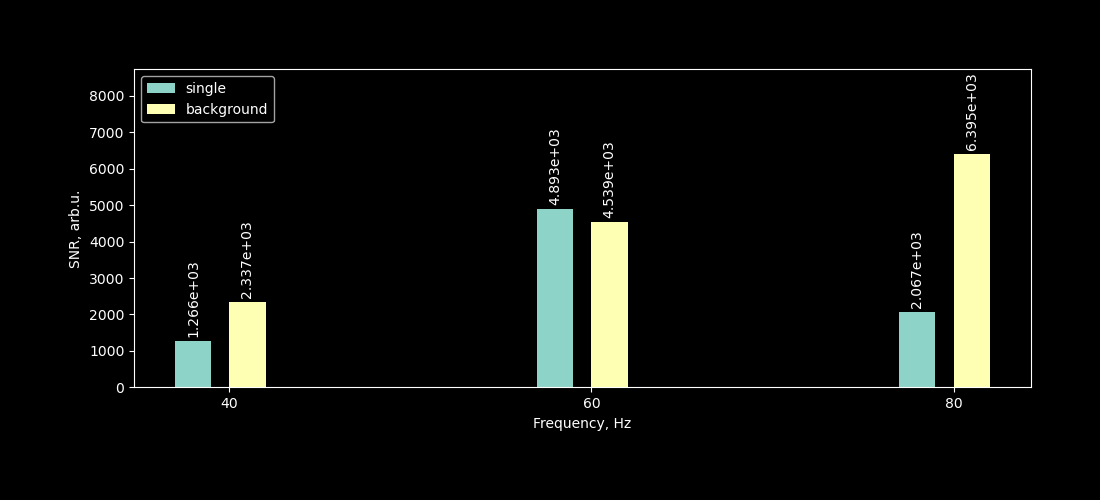

In [46]:
# snrs300 = {
#     'single': [snrs[300][f][0] for f in snrs.index],
#     'background': [snrs[300][f][1] for f in snrs.index]
# }

# snrs600 = {
#     'single': [snrs[600][f][0] for f in snrs.index],
#     'background': [snrs[600][f][1] for f in snrs.index]
# }

snrs900 = {
    'single': [snrs[900][f][0] for f in snrs.index],
    'background': [snrs[900][f][1] for f in snrs.index]
}

frequencies = snrs.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 5), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in snrs300.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('SNR, arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
# multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in snrs600.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('SNR, arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
# multiplier = 0

ax3 = plt.subplot(111)
for k, v in snrs900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()